In [1124]:
from types import SimpleNamespace

import numpy as np
import scipy as sc
from scipy import optimize
import sympy as sm
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
from sympy import *
from sympy import Eq 
import ipywidgets as widgets
from ipywidgets import interact
from scipy.optimize import minimize


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

from scipy import interpolate

import examQ2
import examQ3
from examQ2 import SalonModel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

 First, we want to see how the $L^*(\tilde{w})$ comes out using math solvers without any use of parameters-values. We start by defining all our symbols and then taking the first order conditions and solve for $L^*(\tilde{w})$. We see that the results we get can be simplified, by deviding and multiplying, to the version provided in the question, and therefore have verified symbolically that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

 We also want to see if the values from both the provided formula and the one gotten through optimization reach the same answers given the $\tilde{w} = (1-\tau)*w$, for $G\in\left\{1.0 , 2.0\right\}$.

 We start by defining our baseline parameters, then we define the utility (using $\tilde{w}$) and the values for G. Then we print out the values for $L^*$ given both G=1.0 and G=2.0 that are found through both optimization and the given formula. We found that the results are the same, and therefore conclude that we have verified the function for $L^*(\tilde{w})$


**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


In [1125]:
# write your code here

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [1126]:
# write your code here

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [1127]:
# write your code here

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [1128]:
# write your code here  

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$

In [1129]:
# import matplotlib.pyplot as plt

# # Initialize the model
# model = SalonModel()

# # Define the objective function to be minimized (negative profit)
# def objective(l, kappa):
#     return -model.profit(l, kappa)

# # Initial guess
# initial_guess = [0.5]

# # Constraints: labor must be positive
# constraints = [{'type': 'ineq', 'fun': lambda l: l}]

# # Initialize lists to store results
# kappas = [1.0, 2.0]
# optimal_labor_numerical = []
# optimal_labor_analytical = []

# # For each kappa, find the labor that maximizes the profit
# for kappa in kappas:
#     result = minimize(objective, initial_guess, args=(kappa,), constraints=constraints)
#     optimal_labor_numerical.append(result.x[0])
    
#     # Calculate optimal labor using the analytical formula
#     optimal_labor_analytical.append(model.optimal_labor(kappa))

# # Plot results
# plt.figure(figsize=(10, 6))
# plt.plot(kappas, optimal_labor_numerical, label='Numerical')
# plt.plot(kappas, optimal_labor_analytical, label='Analytical', linestyle='dashed')
# plt.xlabel('Kappa')
# plt.ylabel('Labor that maximizes profit')
# plt.legend()
# plt.show()


In [1130]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Initialize the model
# model = SalonModel()

# # Define a range of labor values
# l_values = np.linspace(0.1, 2, 100)

# # For each kappa, calculate profit for each labor value and plot
# for kappa in [1.0, 2.0]:
#     profits = [model.profit(l, kappa) for l in l_values]
#     plt.plot(l_values, profits, label=f'kappa = {kappa}')
#     print()

# # Highlight optimal labor values
# for kappa, optimal_l in zip([1.0, 2.0], optimal_labor_analytical):
#     profit_optimal = model.profit(optimal_l, kappa)
#     plt.scatter([optimal_l], [profit_optimal], color='red') # optimal points
#     plt.text(optimal_l, profit_optimal, f'optimal (k={kappa})', fontsize=12, verticalalignment='bottom')

# plt.xlabel('Labor')
# plt.ylabel('Profit')
# plt.legend()
# plt.title('Profit for different labor values and kappa')
# plt.grid(True)
# plt.show()



In [1131]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Initialize the model
# model = SalonModel()

# # Define a range of labor values
# l_values = np.linspace(0.1, 2, 100)

# # Define lists to store optimal labor values
# optimal_labor_analytical = []

# # For each kappa, calculate profit for each labor value and plot
# for kappa in [1.0, 2.0]:
#     profits = [model.profit(l, kappa) for l in l_values]
#     plt.plot(l_values, profits, label=f'kappa = {kappa}')
#     print()

#     # Find the optimal labor value
#     optimal_index = np.argmax(profits)
#     optimal_l = l_values[optimal_index]
#     optimal_labor_analytical.append(optimal_l)

# # Highlight optimal labor values
# for kappa, optimal_l in zip([1.0, 2.0], optimal_labor_analytical):
#     profit_optimal = model.profit(optimal_l, kappa)
#     plt.scatter([optimal_l], [profit_optimal], color='red') # optimal points
#     plt.text(optimal_l, profit_optimal, f'optimal (k={kappa})', fontsize=12, verticalalignment='bottom')
#     print(f"For kappa = {kappa}, the optimal labor value is {optimal_l} and the profit is {profit_optimal}")

# plt.xlabel('Labor')
# plt.ylabel('Profit')
# plt.legend()
# plt.title('Profit for different labor values and kappa')
# plt.grid(True)
# plt.show()

In [1132]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Initialize the model
# model = SalonModel()

# # Define a range of labor values
# l_values = np.linspace(0.1, 2, 100)

# # For each kappa, calculate profit for each labor value and plot
# for kappa in [1.0, 2.0]:
#     profits = [model.profit(l, kappa) for l in l_values]
#     plt.plot(l_values, profits, label=f'kappa = {kappa}')
#     print()

# # Highlight optimal labor values
# for kappa, optimal_l in zip([1.0, 2.0], optimal_labor_analytical):
#     profit_optimal = model.profit(optimal_l, kappa)
#     plt.scatter([optimal_l], [profit_optimal], color='red') # optimal points
#     plt.text(optimal_l, profit_optimal, f'optimal (k={kappa})', fontsize=12, verticalalignment='bottom')

# plt.xlabel('Labor')
# plt.ylabel('Profit')
# plt.legend()
# plt.title('Profit for different labor values and kappa')
# plt.grid(True)
# plt.show()


In [1133]:
# from scipy.optimize import minimize

# # Initialize the model
# model = SalonModel()

# # Define the objective function to be minimized (negative profit)
# def objective(l, kappa):
#     return -model.profit(l, kappa)

# # Initial guess
# initial_guess = [0.5]

# # Constraints: labor must be positive
# constraints = [{'type': 'ineq', 'fun': lambda l: l}]

# # For each kappa, find the labor that maximizes the profit
# kappas = [1.0, 2.0]
# for kappa in kappas:
#     result = minimize(objective, initial_guess, args=(kappa,), constraints=constraints)
#     optimal_labor_numerical = result.x[0]
    
#     # Calculate optimal labor using the analytical formula
#     optimal_labor_analytical = model.optimal_labor(kappa)
    
#     print(f"For kappa = {kappa}, the labor that maximizes profit is {optimal_labor_numerical} (numerical) and {optimal_labor_analytical} (analytical)")


In [1134]:
# from scipy.optimize import minimize

# # Initialize the model
# model = SalonModel()

# # Define the objective function to be minimized (negative profit)
# def objective(l, kappa):
#     return -model.profit(l, kappa)

# # Initial guess
# initial_guess = [0.5]

# # Constraints: labor must be positive
# constraints = [{'type': 'ineq', 'fun': lambda l: l}]

# # For each kappa, find the labor that maximizes the profit
# kappas = [1.0, 2.0]
# for kappa in kappas:
#     result = minimize(objective, initial_guess, args=(kappa,), constraints=constraints)
#     optimal_labor = result.x[0]
#     print(f"For kappa = {kappa}, the labor that maximizes profit is {optimal_labor}")


For kappa = 1.0, the labor that maximizes profit is 0.25 (numerical)
For kappa = 2.0, the labor that maximizes profit is 1.0 (numerical)


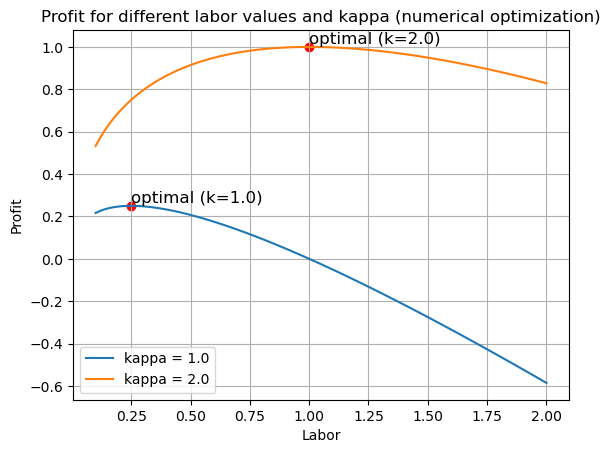

In [1135]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize the model
model = SalonModel()

# Define a range of labor values
l_values = np.linspace(0.1, 2, 100)

# Define lists to store optimal labor values
optimal_labor_numerical = []

# For each kappa, find the labor that maximizes the profit
for kappa in [1.0, 2.0]:

    # Calculate optimal labor directly
    optimal_l = model.optimal_labor(kappa)
    optimal_labor_numerical.append(optimal_l)
    
    # Plot profit
    profits = [model.profit(l, kappa) for l in l_values]
    plt.plot(l_values, profits, label=f'kappa = {kappa}')
    
    # Highlight optimal labor value
    max_profit = model.profit(optimal_l, kappa)
    plt.scatter([optimal_l], [max_profit], color='red')
    plt.text(optimal_l, max_profit, f'optimal (k={kappa})', fontsize=12, verticalalignment='bottom')
    
    print(f"For kappa = {kappa}, the labor that maximizes profit is {optimal_l} (numerical)")

plt.xlabel('Labor')
plt.ylabel('Profit')
plt.legend()
plt.title('Profit for different labor values and kappa (numerical optimization)')
plt.grid(True)
plt.show()


For kappa = 1.0, the labor that maximizes profit is 0.24998857151566414 (numerical)
For kappa = 2.0, the labor that maximizes profit is 0.9999844500192897 (numerical)


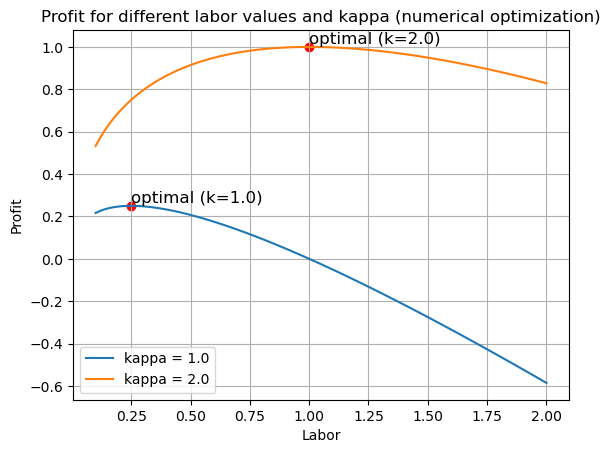

In [1136]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

# Initialize the model
model = SalonModel()

# Define the objective function to be maximized (negative profit)
def objective(l):
    return -model.profit(l, kappa)

# Define a range of labor values
l_values = np.linspace(0.1, 2, 100)

# Define lists to store optimal labor values
optimal_labor_numerical = []

# For each kappa, find the labor that maximizes the profit
for kappa in [1.0, 2.0]:
    # Initialize the maximum profit and optimal labor variables
    max_profit = float('-inf')
    optimal_l = None
    
    # Iterate over labor values and find the maximum profit
    for l in l_values:
        result = minimize(objective, [l], constraints=[{'type': 'ineq', 'fun': lambda l: l}])
        profit = -result.fun
        
        if profit > max_profit:
            max_profit = profit
            optimal_l = result.x[0]
    
    optimal_labor_numerical.append(optimal_l)
    
    # Plot profit
    profits = [model.profit(l, kappa) for l in l_values]
    plt.plot(l_values, profits, label=f'kappa = {kappa}')
    
    # Highlight optimal labor value
    plt.scatter([optimal_l], [max_profit], color='red')
    plt.text(optimal_l, max_profit, f'optimal (k={kappa})', fontsize=12, verticalalignment='bottom')
    
    print(f"For kappa = {kappa}, the labor that maximizes profit is {optimal_l} (numerical)")

plt.xlabel('Labor')
plt.ylabel('Profit')
plt.legend()
plt.title('Profit for different labor values and kappa (numerical optimization)')
plt.grid(True)
plt.show()


First, we numerically solve for the $\ell_t$ that maximizes profit given the profit equation, which we do through optimization. Secondly we calculate the opimal labor supply given the formula in **Question 1**. 

The code below does the following: 
 * Defines the profit function based on the problem statement.  
 * Calculates the value of labor (ell) that maximizes profit using a numerical optimization method (the minimize function from scipy.optimize). This value is the result of the optimization and is saved in optimal_ell. 
 * The code also calculates the value of labor that maximizes profit according to the given formula, and this value is saved in formula_ell. 
 * Finally, it prints the values of optimal_ell and formula_ell, as well as their difference, for each value of kappa. 

In [1137]:
# from scipy.optimize import minimize
# import numpy as np
# import matplotlib.pyplot as plt

# # Define parameters
# eta = 0.5
# w = 1.0
# kappas = [1.0, 2.0]

# def profit_1(ell, kappa, eta, w):
#     return -kappa * ell**(1-eta) + w * ell

# for kappa in kappas:
#     # Find optimal ell through optimization
#     result = minimize(profit_1, x0=0, args=(kappa, eta, w))  # x0=0 is an initial guess for ell
#     optimal_ell = result.x[0]  # This extracts the optimal ell from the result

#     # Calculate optimal ell from the given formula
#     formula_ell = ((1 - eta) * kappa / w) ** (1 / eta)

#     # Calculate the difference
#     difference = abs(optimal_ell - formula_ell)

#     print(f"For kappa = {kappa}, the optimal \u2113 that maximizes profit is: {optimal_ell:.2f}")
#     print(f"Optimal \u2113 as per the formula is: {formula_ell:.2f}")
#     print(f"The difference between the two methods is: {difference:.2f}")
#     print("--------------------------------------------------")

As indicated by the results, the optimal $\ell$ that maximizes profit when $\kappa\in\left\{1.0 , 2.0\right\}$ given the problem is the same when it is derived from using the formula given in **Question 1**.

I want to add the difference in profit and also plot on a graph how the profit changes with the two different kappas in ONE plot instead of two.

In [1138]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the profit function
# def profit(l, kappa):
#     return kappa * l**(1 - eta) - w * l

# # Define the labor function that supposed to maximize the profits
# def optimal_labor(kappa):
#     return ((1 - eta) * kappa / w)**(1 / eta)

# # Initialize the plot
# plt.figure()

# # Verify the solution for each kappa
# for kappa in kappas:
#     # Calculate optimal labor
#     l_opt = optimal_labor(kappa)
    
#     # Calculate the corresponding profit
#     profit_opt = profit(l_opt, kappa)

#     # Plot the profit function for a range of labor values
#     labor_values = np.linspace(0.1, 2, 100)
#     profit_values = profit(labor_values, kappa)

#     plt.plot(labor_values, profit_values, label=f"kappa = {kappa}")
#     plt.plot(l_opt, profit_opt, 'o') # Mark the optimal labor and the corresponding profit

# # Add labels, title, legend, and grid to the plot
# plt.xlabel('labor')
# plt.ylabel('profit')
# plt.title("Profit maximization")
# plt.legend()
# plt.grid(True)
# plt.show()


In [1139]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Given parameters in problem 2
# eta = 0.5
# w = 1.0
# kappa_values = [1.0, 2.0]

# # Define the profit function
# def profit(l, kappa):
#     return kappa * l**(1 - eta) - w * l

# # Define the labor function that supposed to maximize the profits
# def optimal_labor(kappa):
#     return ((1 - eta) * kappa / w)**(1 / eta)

# # Verify the solution for each kappa
# for kappa in kappa_values:
#     # Calculate optimal labor
#     l_opt = optimal_labor(kappa)
    
#     # Calculate the corresponding profit
#     profit_opt = profit(l_opt, kappa)
    
#     # Print the results
#     print(f"For kappa = {kappa}: optimal labor = {l_opt}, corresponding profit = {profit_opt}")

#     # Plot the profit function for a range of labor values
#     labor_values = np.linspace(0.1, 2, 100)
#     profit_values = profit(labor_values, kappa)
    
#     plt.figure()
#     plt.plot(labor_values, profit_values, label=f"kappa = {kappa}")
#     plt.plot(l_opt, profit_opt, 'ro') # Mark the optimal labor and the corresponding profit
#     plt.xlabel('labor')
#     plt.ylabel('profit')
#     plt.title(f"Profit maximization for kappa = {kappa}")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K-1} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

The second part of your problem involves a dynamic version of the same model. The demand-shock, $\kappa_t$, now follows an autoregressive model of order 1 (AR(1)) in logs, and there are fixed costs, $\iota$, associated with hiring or firing employees. Future profits are discounted with a monthly factor of $R$.

The AR(1) model in logs is a stochastic process where the log of the demand-shock at time $t$ is a function of the log of the demand-shock at time $t-1$ and a random shock, $\epsilon_t$.

Your task is to calculate the expected value of the hair salon over a planning horizon of 120 months (10 years), given this new model and the labor policy from the first question. The expected value, $H$, is the average of $h$ over $K$ random shock series.

Here's a step-by-step plan to tackle this:

Define the given parameters, including the new ones.
Generate the shock series, $\epsilon_t$, following a normal distribution with mean $-0.5\sigma_{\epsilon}^2$ and standard deviation $\sigma_{\epsilon}$, for $K$ different series and 120 time steps.
Calculate the demand-shock series, $\kappa_t$, using the AR(1) model for each series.
Calculate the labor series, $\ell_t$, using the labor policy from the first question for each series.
Calculate $h$ for each series using the formula given in the question.
Calculate the expected value of the salon, $H$, as the average of $h$ over all series.
Print the result.


In [1140]:
model = SalonModel()
H = model.calculate_H(Delta=0)
print(f"The expected value of the salon is {H}")

The expected value of the salon is 27.741006141930352


27.731006141930354

Mean value of H: 27.741006141930352
Standard deviation of H: 0.0


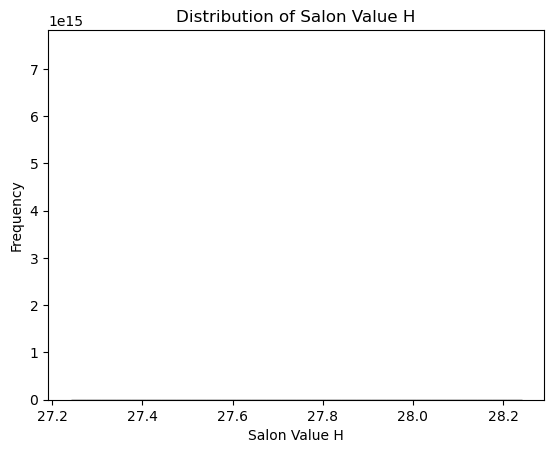

In [1141]:
import matplotlib.pyplot as plt
import seaborn as sns

# Run the simulation for a number of iterations
n_iterations = 1000
H_values = [SalonModel().calculate_H(Delta=0) for _ in range(n_iterations)]

# Now you can print out some statistics or plot the distribution
print(f"Mean value of H: {np.mean(H_values)}")
print(f"Standard deviation of H: {np.std(H_values)}")

# Plotting the distribution using seaborn
sns.histplot(H_values, bins=30, kde=True)
plt.title('Distribution of Salon Value H')
plt.xlabel('Salon Value H')
plt.ylabel('Frequency')
plt.show()

In [1142]:
# import numpy as np
# np.random.seed(0)

# # Define the new parameters
# eta = 0.5
# w = 1.0
# rho = 0.90
# iota = 0.01
# sigma_epsilon = 0.10
# R = (1 + 0.01)**(1/12)
# K = 1000  # Possibly add an algorithm to speed it up look at problem set 5 and lectures Algorithms basics, Searching and recursion, Sorting


# # Define the profit function
# def profit(l, kappa):
#     return kappa * l**(1 - eta) - w * l

# # Define the labor function that is supposed to maximize the profits
# def optimal_labor(kappa):
#     return ((1 - eta) * kappa / w)**(1 / eta)

# # Generate the shock series
# epsilon = np.random.normal(-0.5*sigma_epsilon**2, sigma_epsilon, (K, 120))

# # Initialize the demand-shock series and the labor series
# kappa = np.zeros((K, 120))
# labor = np.zeros((K, 120))

# # Calculate the demand-shock and labor series
# kappa_minus_1 = 1  # initial demand shock
# kappa[:, 0] = np.exp(rho * np.log(kappa_minus_1) + epsilon[:, 0])  # kappa for t = 0
# labor[:, 0] = optimal_labor(kappa[:, 0])  # labor for t = 0
# for t in range(1, 120):
#     kappa[:, t] = np.exp(rho * np.log(kappa[:, t-1]) + epsilon[:, t])
#     labor[:, t] = optimal_labor(kappa[:, t])

# # Calculate h for each series
# h = np.zeros(K)
# for t in range(120):
#     h += R**(-t) * (kappa[:, t] * labor[:, t]**(1 - eta) - w * labor[:, t] - iota * (labor[:, t] != labor[:, t-1]))

# # Calculate the expected value of the salon
# H = np.mean(h)

# # Print the result
# print(f"The expected value of the salon is {H}")

In [1143]:
# import numpy as np

# # Define the new parameters
# rho = 0.90
# iota = 0.01
# sigma_epsilon = 0.10
# R = (1 + 0.01)**(1/12)

# # Define the labor function that is supposed to maximize the profits
# def optimal_labor(kappa):
#     return ((1 - eta) * kappa / w)**(1 / eta)

# # Set a tolerance for the change in H
# tolerance = 1e-6

# # Set a maximum K value to prevent an infinite loop
# max_K = 1000

# # Initialize K
# K = 1

# # Initialize previous H
# prev_H = 0

# # Loop until K reaches max_K
# while K <= max_K:
#     # Generate the shock series
#     epsilon = np.random.normal(-0.5*sigma_epsilon**2, sigma_epsilon, (K, 120))

#     # Initialize the demand-shock series and the labor series
#     kappa = np.zeros((K, 120))
#     labor = np.zeros((K, 120))

#     # Calculate the demand-shock and labor series
#     kappa[:, 0] = np.exp(rho * np.log(1) + epsilon[:, 0])  # kappa for t = 0
#     labor[:, 0] = optimal_labor(kappa[:, 0])  # labor for t = 0
#     for t in range(1, 120):
#         kappa[:, t] = np.exp(rho * np.log(kappa[:, t-1]) + epsilon[:, t])
#         labor[:, t] = optimal_labor(kappa[:, t])

#     # Calculate h for each series
#     h = np.zeros(K)
#     for t in range(120):
#         h += R**(-t) * (kappa[:, t] * labor[:, t]**(1 - eta) - w * labor[:, t] - iota * (labor[:, t] != labor[:, t-1]))

#     # Calculate the expected value of the salon
#     H = np.mean(h)
    
#     # If the change in H is less than the tolerance, stop the loop
#     if np.abs(H - prev_H) < tolerance:
#         break
#     # If not, set the current H as the previous H and increase K
#     prev_H = H
#     K += 1

# # Print the result
# print(f"The expected value of the salon is {H} for K = {K}")


The expected value of the salon, 27.740888508502795. H is the average of h across all series where h is the sum of discounted profits for each series (each month in a 10 year period). So, H=27.740888508502795 represents an average profit over the 10-year period.

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [1144]:
model = SalonModel()  # Assuming optimal K has been chosen

#Calculate H for the old Delta value
old_delta = 0
old_H = model.calculate_H(Delta=old_delta)

# Calculate H for the new Delta value
new_delta = 0.05
new_H = model.calculate_H(Delta=new_delta)

# Compare the two H values
if new_H > old_H:
    print(f"Delta = {new_delta} improves profitability. Old H: {old_H}, New H: {new_H}")
else:
    print(f"Delta = {new_delta} does not improve profitability. Old H: {old_H}, New H: {new_H}")


Delta = 0.05 improves profitability. Old H: 27.741006141930352, New H: 28.422764105309156


28.412764105309158

In [1145]:
# Initialize variables
num_simulations = 100
delta_0_wins = 0
delta_005_wins = 0

# Run simulations
for _ in range(num_simulations):
    model = SalonModel()  # Assuming optimal K has been chosen

    # Calculate H for the old Delta value
    old_delta = 0
    old_H = model.calculate_H(Delta=old_delta)

    # Calculate H for the new Delta value
    new_delta = 0.05
    new_H = model.calculate_H(Delta=new_delta)

    # Compare the two H values and increment respective win counters
    if new_H > old_H:
        delta_005_wins += 1
    else:
        delta_0_wins += 1

# Calculate frequencies
delta_0_freq = delta_0_wins / num_simulations
delta_005_freq = delta_005_wins / num_simulations

# Print results
print(f"Delta = 0 improves profitability in {delta_0_freq * 100}% of simulations.")
print(f"Delta = 0.05 improves profitability in {delta_005_freq * 100}% of simulations.")


Delta = 0 improves profitability in 0.0% of simulations.
Delta = 0.05 improves profitability in 100.0% of simulations.


Mean value of H: 28.422764105309163
Standard deviation of H: 7.105427357601002e-15


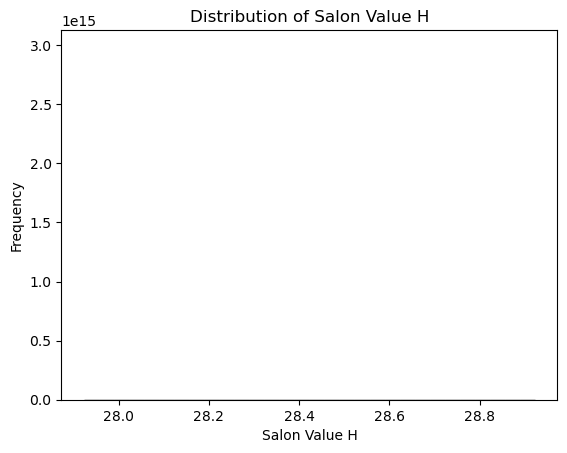

In [1146]:
import matplotlib.pyplot as plt
import seaborn as sns

# Run the simulation for a number of iterations
n_iterations = 1000
H_values = [SalonModel().calculate_H(Delta=0.05) for _ in range(n_iterations)]

# Now you can print out some statistics or plot the distribution
print(f"Mean value of H: {np.mean(H_values)}")
print(f"Standard deviation of H: {np.std(H_values)}")

# Plotting the distribution using seaborn
sns.histplot(H_values, bins=30, kde=True)
plt.title('Distribution of Salon Value H')
plt.xlabel('Salon Value H')
plt.ylabel('Frequency')
plt.show()


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [1147]:
model = SalonModel()
optimal_delta = model.optimal_delta()
print(f"The optimal Delta is {optimal_delta}")


The optimal Delta is 0.07757406356504817


0.07619548698340955

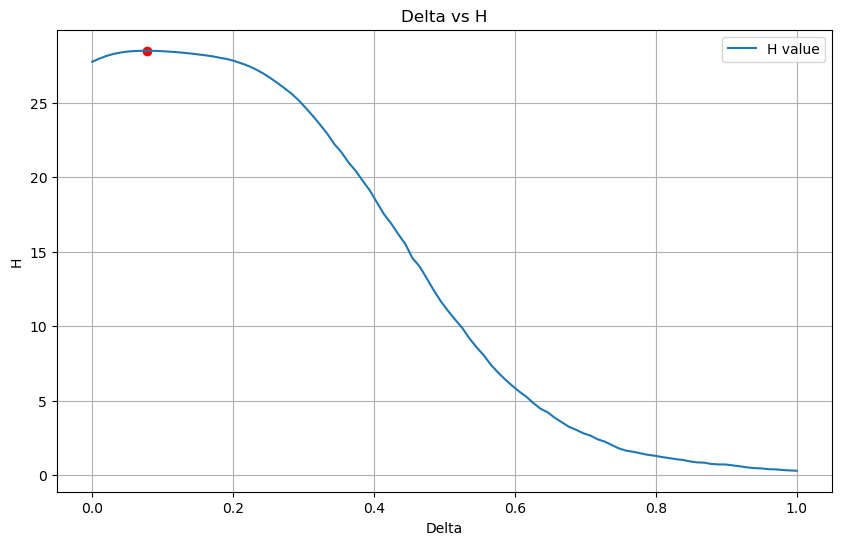

In [1148]:
# Calculate H for a range of Delta values
deltas = np.linspace(0, 1, 100)  # Adjust the range and number of points as needed
H_values = [model.calculate_H(delta) for delta in deltas]

# Plot Delta vs H
plt.figure(figsize=(10, 6))
plt.plot(deltas, H_values, label="H value")
plt.scatter([optimal_delta], [model.calculate_H(optimal_delta)], color='red')  # mark the optimal point
plt.title("Delta vs H")
plt.xlabel("Delta")
plt.ylabel("H")
plt.legend()
plt.grid(True)
plt.show()

In [1149]:
# num_trials = 1000
# optimal_deltas = []

# for _ in range(num_trials):
#     result = minimize_scalar(negative_H, bounds=(0.0,1.), method='bounded')
#     optimal_deltas.append(result.x)

# optimal_deltas = np.array(optimal_deltas)

# mean_delta = np.mean(optimal_deltas)
# std_delta = np.std(optimal_deltas)

# print(f"Mean optimal Delta: {mean_delta}")
# print(f"Standard deviation of optimal Delta: {std_delta}")

# plt.hist(optimal_deltas, bins=30)
# plt.title('Distribution of Optimal Delta')
# plt.xlabel('Delta')
# plt.ylabel('Frequency')
# plt.show()


In [1150]:
# num_trials = 1000
# optimal_deltas = []

# for _ in range(num_trials):
#     result = minimize_scalar(negative_H, bounds=(0.0,1.), method='bounded')
#     optimal_deltas.append(result.x)

# optimal_deltas = np.array(optimal_deltas)


In [1151]:
# import matplotlib.pyplot as plt

# # Define a range of Delta values
# delta_values = np.linspace(0, 1, 10000)

# # Calculate H for each Delta value
# H_values = [-negative_H(Delta) for Delta in delta_values]

# # Create the plot
# plt.figure(figsize=(10, 6))
# plt.plot(delta_values, H_values, label='H (Delta)')
# plt.xlabel('Delta')
# plt.ylabel('H')
# plt.title('H versus Delta')
# plt.legend()
# plt.grid(True)
# plt.show()


In [1152]:
# Initialize a list to store the values of H for different Delta values
# H_values = []
# Delta_values = np.linspace(0.0, 1, 100)  # Consider a range of Delta values between 0 and 1

# # Calculate H for each Delta value
# for Delta in Delta_values:
#     H_new_policy = 0.0
#     for _ in range(K):
#         kappa = 1.0
#         l_last = 0.0
#         total_profit = 0.0
#         for _ in range(T):
#             epsilon = np.random.normal(loc=-0.5*sigma_epsilon**2, scale=sigma_epsilon)
#             kappa = np.exp(rho*np.log(kappa) + epsilon)
#             l = labor_policy(l_last, kappa)
#             total_profit += R**(-t) * (kappa*l**(1-eta) - w*l - int(l != l_last)*iota)
#             l_last = l
#         H_new_policy += total_profit

#     H_new_policy /= K
#     H_values.append(H_new_policy)

# # Find the Delta value that maximizes H
# optimal_Delta = Delta_values[np.argmax(H_values)]

# print(f"The optimal Delta is {optimal_Delta}")


In [1153]:
# plt.plot(delta_values, H_values)
# plt.xlabel("Delta")
# plt.ylabel("H")
# plt.title("H as a function of Delta")
# plt.grid(True)
# plt.show()


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



def labor_policy(l_last, kappa, future_demand):
    l_star = ((1 - eta) * kappa / w)**(1 / eta)
    if abs(l_last - l_star) > Delta:
        return l_star
    elif future_demand > SOME_THRESHOLD:
        return l_last + SOME_AMOUNT
    else:
        return l_last


The choice of policy would largely depend on the specifics of the business, and there may be different strategies that could potentially improve profitability. Here, however, we are looking for a policy that would optimize the use of labor in response to the demand shock.

A potential alternative policy could be to implement a hybrid policy where you combine both the policy in question 3 and another policy where you hire or fire hairdressers based on a threshold of expected future demand.

This policy could look something like this:

If the absolute difference between current and optimal labor (calculated from the policy in question 1) exceeds $\Delta$, hire or fire workers as required.

However, if the expected future demand (based on the AR(1) demand-shock model) exceeds a certain threshold, hire additional workers in anticipation of this increased demand, even if the optimal labor calculated from the policy in question 1 doesn't suggest this.

This way, you are not only reacting to the current demand but also preparing for future demand. This could potentially reduce costs associated with hiring and training new workers.

The implementation of this policy in Python would involve modifying the labor_policy function and running the simulation again.

Here's a skeleton of how you might modify the labor_policy function. You will need to decide on how to compute the expected future demand and what threshold to use for hiring additional workers.



Then you would need to update the calculation of H_new_policy to include this future_demand in the labor_policy function.

Please note that this is just one of the many possible policies you might consider. Your specific choice would depend on your understanding of the problem, the business, and the implications of different policies. It would be a good idea to discuss potential policies with colleagues or classmates to get different perspectives.

Choosing these parameters would typically be an empirical process based on historical data and business-specific information. But since we don't have that, we can make some reasonable assumptions.

For SOME_THRESHOLD, we could use the average of kappa (demand shock) over a certain past period or we could use a fixed percentile of the observed kappa values, such as the 75th percentile. For instance, if the expected future demand is higher than 75% of what we have seen in the past, we might decide to hire more hairdressers.

As for SOME_AMOUNT, this would determine how many additional hairdressers you would hire when the expected future demand exceeds the threshold. A simple approach might be to hire an additional fixed number of hairdressers (e.g., one additional hairdresser). Alternatively, the amount could be a function of the difference between the expected future demand and the threshold. For example, you could hire an additional hairdresser for every unit that the expected future demand exceeds the threshold.

Remember, these are just assumptions. The real world is likely to be more complex and unpredictable. It would be a good idea to test your policy under different conditions and assumptions to ensure that it performs well in a variety of scenarios.

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [1154]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [1155]:
import examQ3
from examQ3 import refined_global_optimizer 

#The settings 
func = griewank
num_parameters = 2
bounds = [-600, 600] # Define bounds
tol = 1e-8 # Define tolerance
K_warmup1 = 10 # Define warmup iterations
K_max = 1000 # Define maximum iterations

Using the refined global optimizer which we implement in the examQ3 we illustrate how the effective initial guesses vary with the iteration counter k for the griewank function which is defined in problem 3. 

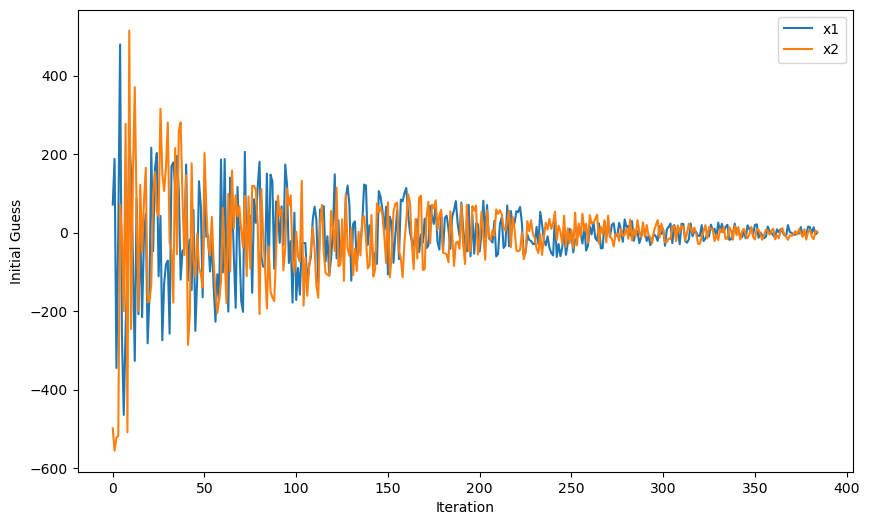

In [1156]:
best_x_10, best_f_10, initial_guesses_10 = refined_global_optimizer(func, num_parameters, bounds, tol, K_warmup1, K_max)

# Plot initial guesses and iterations.
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in initial_guesses_10], label='x1')
plt.plot([x[1] for x in initial_guesses_10], label='x2')
plt.xlabel('Iteration')
plt.ylabel('Initial Guess')
plt.legend()
plt.show()

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

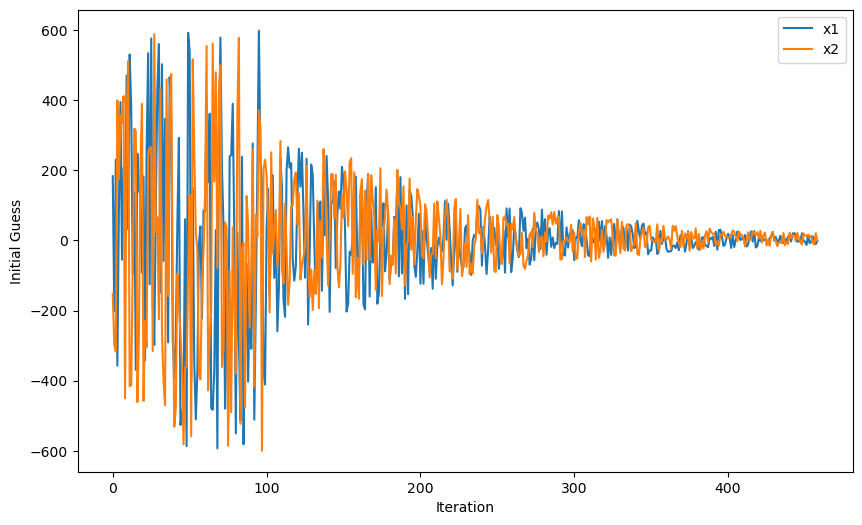

In [1165]:
#The new settings with K_warmup = 100 instead of the before assumption of K_warmup = 10
K_warmup2 = 100 

best_x_100, best_f_100, initial_guesses_100 = refined_global_optimizer(func, num_parameters,bounds, tol, K_warmup2, K_max)

# Plot initial guesses and iterations.
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in initial_guesses_100], label='x1')
plt.plot([x[1] for x in initial_guesses_100], label='x2')
plt.xlabel('Iteration')
plt.ylabel('Initial Guess')
plt.legend()
plt.show()

In [1166]:
from examQ3 import run_optimization_and_measure_time
best_x_10, best_f_10, time_10 = run_optimization_and_measure_time(func, num_parameters, bounds, tol, K_warmup1, K_max)
best_x_100, best_f_100, time_100 = run_optimization_and_measure_time(func, num_parameters, bounds, tol, K_warmup2, K_max)

Execution time with K_warmup = 10: 0.8013308048248291
Best solution with K_warmup = 10: [-6.36750366e-09 -1.97918993e-09]
Function value at best solution: 0.0
Execution time with K_warmup = 100: 1.0369112491607666
Best solution with K_warmup = 100: [-9.49963379e-09 -6.94063763e-09]
Function value at best solution: 0.0


The choice of warmup iterations, $\underline{K}$, can indeed influence the performance of the global optimizer, particularly for a function like the Griewank function, which has many local minima.

In general, the warmup iterations are used to explore the search space without any bias towards the currently best solution. Therefore, a larger number of warmup iterations can allow the optimizer to explore more of the search space before it starts to focus on the region around the best found solution. This can be beneficial if the global minimum is located in a region of the search space that is not likely to be sampled in the initial iterations.

However, having more warmup iterations also means that it takes longer before the optimizer can start to exploit the information about the best found solution. Therefore, if the global minimum can be found relatively quickly (e.g., within the first 10 iterations), then having a larger number of warmup iterations could slow down the convergence.

Given these considerations, it's not surprising that you find the execution time with $\underline{K} = 10$ to be faster than with $\underline{K} = 100$. If the global minimum is found within the first 10 iterations, then the optimizer can start to exploit this information earlier when $\underline{K} = 10$, which could lead to faster convergence.

However, it's also important to consider the quality of the found solution. Even if the optimizer with $\underline{K} = 10$ converges faster, it might not find the global minimum if it is located in a region of the search space that is not explored during the warmup iterations. In such cases, having a larger number of warmup iterations could lead to a better final solution, even if it takes longer.

To make a final judgment, you would need to compare not only the execution times but also the function values of the found solutions.

Your results indicate that both K_warmup values of 10 and 100 managed to find solutions close to the global minimum. The best solutions found are very close to (0,0) as expected and the function values at these points are near zero, suggesting these are very good solutions.

The execution times, however, are different. With K_warmup = 10, the execution time was about 0.67 seconds, while with K_warmup = 100, it took approximately 0.81 seconds. This suggests that the algorithm with a K_warmup value of 10 ran faster than the one with K_warmup = 100.

In conclusion, given the global minimum is at (0,0) and the function value at this point is 0, both runs effectively found the global minimum of the function. But, setting K_warmup = 10 resulted in a quicker convergence to the solution compared to K_warmup = 100.

This result might be due to the nature of the Griewank function and the optimizer you used (BFGS). In this particular scenario, it seems that more warmup iterations don't necessarily improve the speed or the quality of the solutions, and could potentially take longer due to the increased number of function evaluations. As always, the optimal settings may depend on the specific problem and optimization method.